# [**Transformations de caractéristiques avec des ensembles d'arbres**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/1_11_ensemble/plot_feature_transformation.ipynb)<br/>([_Feature transformations with ensembles of trees_](https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html))

Transformez vos caractéristiques en un espace creux de plus grande dimension. Entraînez ensuite un modèle linéaire sur ces caractéristiques.

Ajustez d'abord un ensemble d'arbres (arbres totalement aléatoires, une forêt aléatoire ou des arbres à amplification de gradient) sur l'ensemble d'entraînement. Ensuite, chaque feuille de chaque arbre de l'ensemble se voit attribuer un index de caractéristiques arbitraire fixe dans un nouvel espace de caractéristiques. Ces indices de feuilles sont ensuite codés en *one-hot*.

Chaque échantillon passe par les décisions de chaque arbre de l'ensemble et aboutit à une feuille par arbre. L'échantillon est codé en définissant les valeurs de caractéristique de ces feuilles sur 1 et les autres valeurs de caractéristique sur 0.

Le transformateur résultant a ensuite appris un plongement catégoriel supervisé, creux et de grande dimension des données.

In [1]:
# Author: Tim Head <betatim@gmail.com>
#
# License: BSD 3 clause

Tout d'abord, nous allons créer un grand ensemble de données et le diviser en trois ensembles :

* un ensemble pour entraîner les méthodes ensemblistes qui sont ensuite utilisées comme transformateur d'ingénierie de caractéristiques;
* un ensemble pour entraîner le modèle linéaire ;
* un ensemble pour tester le modèle linéaire.

Il est important de diviser les données de manière à éviter le sur-ajustement par fuite de données.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(n_samples=80_000, random_state=10)

X_full_train, X_test, y_full_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=10
)
X_train_ensemble, X_train_linear, y_train_ensemble, y_train_linear = train_test_split(
    X_full_train, y_full_train, test_size=0.5, random_state=10
)

Pour chacune des méthodes ensembliste, nous utiliserons 10 estimateurs et une profondeur maximale de 3 niveaux.

In [3]:
n_estimators = 10
max_depth = 3

Commençons par entraîner la forêt aléatoire et l'amplification du gradient sur l'ensemble d'entraînement séparé

In [4]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

random_forest = RandomForestClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)
random_forest.fit(X_train_ensemble, y_train_ensemble)

gradient_boosting = GradientBoostingClassifier(
    n_estimators=n_estimators, max_depth=max_depth, random_state=10
)
_ = gradient_boosting.fit(X_train_ensemble, y_train_ensemble)

Notez que [**`HistGradientBoostingClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html#sklearn.ensemble.HistGradientBoostingClassifier) est beaucoup plus rapide que [**`GradientBoostingClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier) à partir de jeux de données intermédiaires `(n_samples >= 10_000)`, ce qui n'est pas le cas du présent exemple.

Le [**`RandomTreesEmbedding`**](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomTreesEmbedding.html#sklearn.ensemble.RandomTreesEmbedding) est une méthode non supervisée et ne nécessite donc pas d'entraînement indépendant.

In [5]:
from sklearn.ensemble import RandomTreesEmbedding

random_tree_embedding = RandomTreesEmbedding(
    n_estimators=n_estimators, max_depth=max_depth, random_state=0
)

Maintenant, nous allons créer trois pipelines qui utiliseront le plongement ci-dessus comme étape de prétraitement.

Le plongement d'arbres aléatoires peut être directement mise en pipeline avec la régression logistique car il s'agit d'un transformateur scikit-learn standard.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

rt_model = make_pipeline(random_tree_embedding, LogisticRegression(max_iter=1000))
rt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('randomtreesembedding',
                 RandomTreesEmbedding(max_depth=3, n_estimators=10,
                                      random_state=0)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Ensuite, nous pouvons construire un pipeline avec une forêt aléatoire ou une amplification de gradient avec une régression logistique. Cependant, la transformation de caractéristique se produira en appelant la méthode `apply`. Le pipeline dans scikit-learn attend un appel à `transform`. Par conséquent, nous avons enveloppé l'appel à `apply` dans un [**`FunctionTransformer`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html#sklearn.preprocessing.FunctionTransformer).

In [7]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder


def rf_apply(X, model):
    return model.apply(X)


rf_leaves_yielder = FunctionTransformer(rf_apply, kw_args={"model": random_forest})

rf_model = make_pipeline(
    rf_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000),
)
rf_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function rf_apply at 0x000001EA16C965C0>,
                                     kw_args={'model': RandomForestClassifier(max_depth=3,
                                                                              n_estimators=10,
                                                                              random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [8]:
def gbdt_apply(X, model):
    return model.apply(X)[:, :, 0]


gbdt_leaves_yielder = FunctionTransformer(
    gbdt_apply, kw_args={"model": gradient_boosting}
)

gbdt_model = make_pipeline(
    gbdt_leaves_yielder,
    OneHotEncoder(handle_unknown="ignore"),
    LogisticRegression(max_iter=1000),
)
gbdt_model.fit(X_train_linear, y_train_linear)

Pipeline(steps=[('functiontransformer',
                 FunctionTransformer(func=<function gbdt_apply at 0x000001EA16C96700>,
                                     kw_args={'model': GradientBoostingClassifier(n_estimators=10,
                                                                                  random_state=10)})),
                ('onehotencoder', OneHotEncoder(handle_unknown='ignore')),
                ('logisticregression', LogisticRegression(max_iter=1000))])

Nous pouvons enfin montrer les différentes courbes ROC pour tous les modèles.

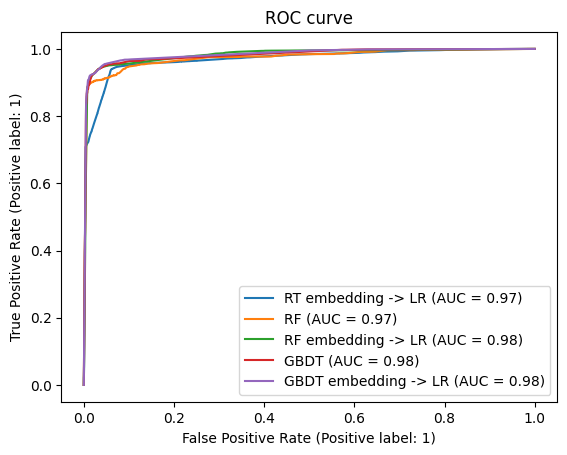

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots()

models = [
    ("RT embedding -> LR", rt_model),
    ("RF", random_forest),
    ("RF embedding -> LR", rf_model),
    ("GBDT", gradient_boosting),
    ("GBDT embedding -> LR", gbdt_model),
]

model_displays = {}
for name, pipeline in models:
    model_displays[name] = RocCurveDisplay.from_estimator(
        pipeline, X_test, y_test, ax=ax, name=name
    )
_ = ax.set_title("ROC curve")

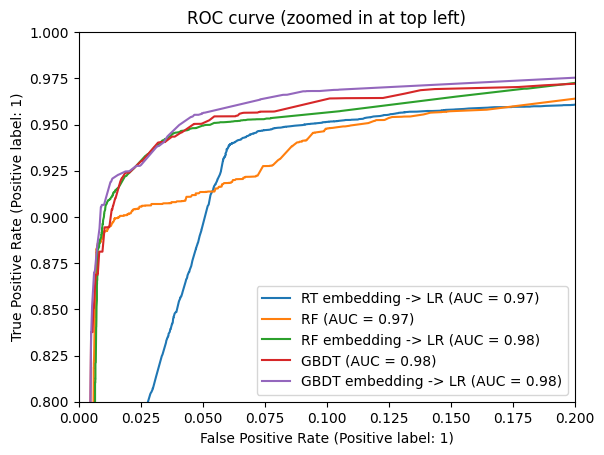

In [10]:
fig, ax = plt.subplots()
for name, pipeline in models:
    model_displays[name].plot(ax=ax)

ax.set_xlim(0, 0.2)
ax.set_ylim(0.8, 1)
_ = ax.set_title("ROC curve (zoomed in at top left)")